In [29]:
import os
import re
import json
import random
import textwrap
import pandas as pd
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

In [ ]:
# Define a function to pretty-print JSON with wrapped lines
def pretty_print_json(data, max_width=80):
    json_str = json.dumps(data, indent=4)
    wrapped_lines = []
    for line in json_str.splitlines():
        wrapped_lines.extend(textwrap.wrap(line, width=max_width))
    return "\n".join(wrapped_lines)

file_path = os.path.join("eval_baseline_emrqa", "eval_predictions.jsonl")
with open(file_path, "r") as file:
    predictions = [json.loads(line) for line in file]

# Filter failed examples where the predicted answer does not match the expected answer
failed_examples = [
    prediction for prediction in predictions
    if prediction['predicted_answer'] != prediction['answers']['text'][0] # for whatever reason this is a list
]

# Put Failed examples in a dataframe
failed = pd.DataFrame(failed_examples)
failed['answer'] = [v['text'][0] for v in failed["answers"].values]
# pd.set_option('display.max_colwidth', 20)
failed.columns
len(failed)

3248

In [ ]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)
failed[failed['question'].str.lower().str.startswith('has')].head(50)
gemfibrozil_examples = failed[failed['question'].str.lower().str.contains('gemfibrozil')]
gemfibrozil_examples

In [ ]:
len(failed[failed['Predicted Answer'] == ',']), len(failed[failed['Predicted Answer'] == '.'])

###  Baseline EMRQA prediction error analysis
- High-level error patterns for `eval_baseline_emrqa/eval_predictions.jsonl`
- Label wrong predictions as `truncated_span`, `overlong_span`, `partial_overlap`, or `no_overlap` and show counts/examples.

In [12]:
# Helpers
token_re = re.compile(r"\w+")
relation = ["truncated_span", "overlong_span", "partial_overlap", "no_overlap"]

def norm(text):
    return " ".join(text.lower().split())

def tokens(text: str):
    return token_re.findall(text.lower())

def span_relation(prediction: str, actual: str):
    p = norm(prediction)
    a = norm(actual)
    if p and p in a:
        return relation[0]
    if a and a in p:
        return relation[1]
    if set(tokens(p)) & set(tokens(a)):
        return relation[2]
    return relation[3]

# Add a new column to the failed dataframe for the span relation
failed['relation'] = failed.apply(
    lambda row: span_relation(
        row.get("predicted_answer", "") or "",
        row.get("answer", "") or ""
    ),
    axis=1
)

# Display counts from the failed dataframe
print(f"Total wrong predictions: {len(failed)}")
print("Wrong predictions by type:")
print(failed["relation"].value_counts())

# Use the following filter to deep dive
# failed[failed["relation"] == relation[0]][["id", "question", "predicted_answer", "answer"]].head(5)

Total wrong predictions: 3248
Wrong predictions by type:
relation
truncated_span     2714
overlong_span       272
partial_overlap     193
no_overlap           69
Name: count, dtype: int64


### Deep Dive into Baseline EMRQA Prediction Errors

In [38]:
failed['gold_norm'] = failed['answer'].apply(norm)
failed['pred_norm'] = failed['predicted_answer'].apply(norm)
failed["clust_text"] = failed.apply(
    lambda r: f"Q: {r['question']} GOLD: {r['gold_norm']} PRED: {r['pred_norm']}",
    axis=1
)

In [42]:
vectorizer = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    min_df=5
)

X = vectorizer.fit_transform(failed["clust_text"])
X.shape

(3248, 3000)

In [43]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=100)
cluster_labels = kmeans.fit_predict(X)

failed["cluster"] = cluster_labels
cluster_sizes = failed["cluster"].value_counts().sort_index()
cluster_sizes

cluster
0      81
1     217
2     448
3     249
4    1328
5     193
6     228
7     156
8      76
9     272
Name: count, dtype: int64

Per Cluster Analysis

In [46]:
cluster_summaries = {}

for c in sorted(failed["cluster"].unique()):
    sub = failed[failed["cluster"] == c]

    qs = sub["question"].astype(str).tolist()
    if len(qs) < 5:
        continue

    cv = CountVectorizer(
        max_features=2000,
        ngram_range=(1,3),
        stop_words="english"
    )
    Xq = cv.fit_transform(qs)

    sums = np.asarray(Xq.sum(axis=0)).ravel()
    terms = np.array(cv.get_feature_names_out())
    top_idx = sums.argsort()[::-1][:15]

    cluster_summaries[c] = {
        "n": len(sub),
        "top_terms": list(terms[top_idx]),
        "error_dist": sub["relation"].value_counts().to_dict()
    }

cluster_summaries

{np.int32(0): {'n': 81,
  'top_terms': ['patient',
   'darvocet',
   '100',
   'darvocet 100',
   'pain',
   'roxicet',
   'acetaminophen',
   'darvocet 100 propoxyphene',
   '100 propoxyphene nap',
   'nap',
   'propoxyphene nap acetaminophen',
   'nap acetaminophen',
   'propoxyphene',
   'propoxyphene nap',
   '100 propoxyphene'],
  'error_dist': {'truncated_span': 63, 'overlong_span': 18}},
 np.int32(1): {'n': 217,
  'top_terms': ['patient',
   'lopressor',
   'prescribed',
   'nitroglycerin',
   'patient prescribed',
   'isordil',
   'tried',
   'patient tried',
   'current dose',
   'dose',
   'current',
   'pain',
   'past',
   'does',
   'does patient'],
  'error_dist': {'truncated_span': 207,
   'partial_overlap': 6,
   'no_overlap': 4}},
 np.int32(2): {'n': 448,
  'top_terms': ['patient',
   'does patient',
   'does',
   'current dose',
   'current',
   'dose',
   'insulin',
   'lasix',
   'prescribed',
   'colace',
   'nph',
   'patient prescribed',
   'patient tried',
   't

In [47]:
for c in sorted(cluster_summaries.keys()):
    info = cluster_summaries[c]
    print("="*70)
    print(f"Cluster {c}  |  n = {info['n']}")
    print("Top terms:", ", ".join(info["top_terms"]))
    print("Error types:", info["error_dist"])
    print()

Cluster 0  |  n = 81
Top terms: patient, darvocet, 100, darvocet 100, pain, roxicet, acetaminophen, darvocet 100 propoxyphene, 100 propoxyphene nap, nap, propoxyphene nap acetaminophen, nap acetaminophen, propoxyphene, propoxyphene nap, 100 propoxyphene
Error types: {'truncated_span': 63, 'overlong_span': 18}

Cluster 1  |  n = 217
Top terms: patient, lopressor, prescribed, nitroglycerin, patient prescribed, isordil, tried, patient tried, current dose, dose, current, pain, past, does, does patient
Error types: {'truncated_span': 207, 'partial_overlap': 6, 'no_overlap': 4}

Cluster 2  |  n = 448
Top terms: patient, does patient, does, current dose, current, dose, insulin, lasix, prescribed, colace, nph, patient prescribed, patient tried, tried, previous
Error types: {'truncated_span': 389, 'partial_overlap': 35, 'overlong_span': 19, 'no_overlap': 5}

Cluster 3  |  n = 249
Top terms: patient, prescribed, current, current dose, dose, patient prescribed, does, does patient, xl, meds, prior

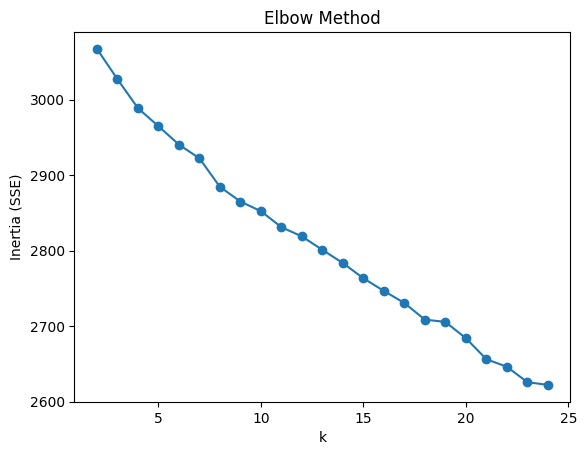

In [49]:
ks = list(range(2, 25))
sse = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=200)
    km.fit(X)
    sse.append(km.inertia_)

plt.plot(ks, sse, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method")
plt.show()

Cluster error types in failed examples for further analysis.

In [36]:
model = SentenceTransformer("all-mpnet-base-v2")

embed_texts = failed["clust_text"].tolist()
embeddings = model.encode(
    embed_texts,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)

embeddings.shape

Batches: 100%|██████████| 51/51 [00:02<00:00, 18.27it/s]


(3248, 768)

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca_2d = pca.fit_transform(embeddings)

failed["pca_x"] = pca_2d[:, 0]
failed["pca_y"] = pca_2d[:, 1]

k= 2  silhouette=0.0633
k= 3  silhouette=0.0604
k= 4  silhouette=0.0472
k= 5  silhouette=0.0576
k= 6  silhouette=0.0578
k= 7  silhouette=0.0603
k= 8  silhouette=0.0605
k= 9  silhouette=0.0589
k=10  silhouette=0.0440
k=11  silhouette=0.0629
k=12  silhouette=0.0519
k=13  silhouette=0.0473
k=14  silhouette=0.0541
k=15  silhouette=0.0521


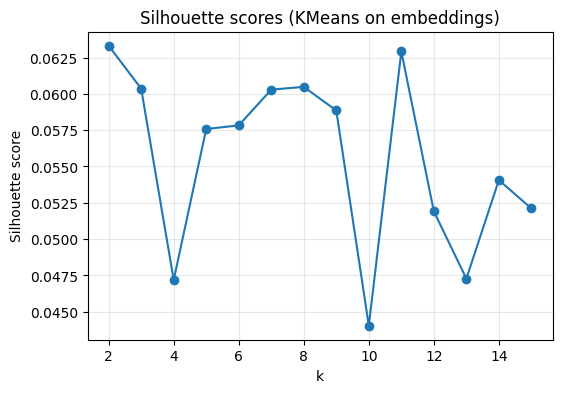

In [51]:
from sklearn.metrics import silhouette_score

ks = list(range(2, 16))
sil_scores = []

for k in ks:
    km = KMeans(
        n_clusters=k,
        random_state=0,
        n_init=10,
        max_iter=300
    )
    labels = km.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    sil_scores.append(score)
    print(f"k={k:2d}  silhouette={score:.4f}")

plt.figure(figsize=(6,4))
plt.plot(ks, sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette scores (KMeans on embeddings)")
plt.grid(True, alpha=0.3)
plt.show()

In [54]:
from sklearn.cluster import KMeans

best_k = 8  # <-- replace with your chosen k

kmeans = KMeans(
    n_clusters=best_k,
    random_state=0,
    n_init=10,
    max_iter=300
)
k_labels = kmeans.fit_predict(embeddings)

failed["cluster_kmeans"] = k_labels
failed["cluster_kmeans"].value_counts().sort_index()

cluster_kmeans
0    321
1    333
2    372
3    622
4    761
5    176
6    431
7    232
Name: count, dtype: int64

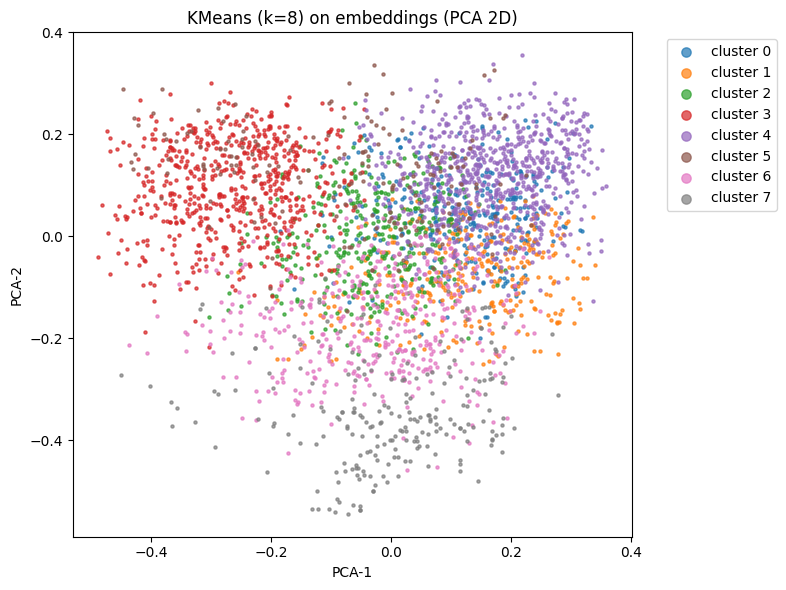

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for cid in sorted(failed["cluster_kmeans"].unique()):
    mask = failed["cluster_kmeans"] == cid
    plt.scatter(
        failed.loc[mask, "pca_x"],
        failed.loc[mask, "pca_y"],
        s=5,
        alpha=0.7,
        label=f"cluster {cid}"
    )

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.title(f"KMeans (k={best_k}) on embeddings (PCA 2D)")
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

cluster_k_info = {}

for cid in sorted(failed["cluster_kmeans"].unique()):
    sub = failed[failed["cluster_kmeans"] == cid]
    n = len(sub)
    rel_dist = sub["relation"].value_counts().to_dict()
    
    top_terms = []
    if n >= 5:
        cv = CountVectorizer(
            max_features=2000,
            ngram_range=(1,2),
            stop_words="english"
        )
        Xq = cv.fit_transform(sub["question"].astype(str).tolist())
        sums = np.asarray(Xq.sum(axis=0)).ravel()
        terms = np.array(cv.get_feature_names_out())
        top_idx = sums.argsort()[::-1][:15]
        top_terms = list(terms[top_idx])
    
    cluster_k_info[cid] = {
        "n": n,
        "relation_dist": rel_dist,
        "top_terms": top_terms,
    }

for cid, info in cluster_k_info.items():
    print("="*80)
    print(f"Cluster {cid}  |  n = {info['n']}")
    print("Error-type distribution:", info["relation_dist"])
    print("Top question terms:", ", ".join(info["top_terms"]))
    print()

Cluster 0  |  n = 321
Error-type distribution: {'truncated_span': 184, 'overlong_span': 107, 'partial_overlap': 24, 'no_overlap': 6}
Top question terms: patient, prescribed, coumadin, patient prescribed, past, tried, patient tried, medications, levofloxacin, heparin, used, infection, record, vancomycin, history

Cluster 1  |  n = 333
Error-type distribution: {'truncated_span': 297, 'no_overlap': 18, 'partial_overlap': 16, 'overlong_span': 2}
Top question terms: patient, past, prescribed, medications, tried, patient tried, patient prescribed, did, did patient, medications patient, medication, used, blood, blood pressure, pressure

Cluster 2  |  n = 372
Error-type distribution: {'truncated_span': 318, 'overlong_span': 33, 'partial_overlap': 12, 'no_overlap': 9}
Top question terms: prior, record, usage prescription, usage, prescription record, prescription, mention, history, use, history use, previous, patient, pt, xl, lopressor

Cluster 3  |  n = 622
Error-type distribution: {'truncated_

### Manual Review of Sampled Errors

- No. of questions in the train dataset that start with "has" is 62872/130,956
- No. of questions in the validation dataset that start with "has" is 15913/32739
- No. of questions in the failed examples that start with "has" is 1423/3248

This examines the whole dataset for train and eval to see how many questions start with "has", 'why' etc.

In [ ]:
from datasets import load_dataset
train = load_dataset("Eladio/emrqa-msquad", split="train")

# Filter questions that start with "why"
why_questions = train.filter(lambda example: example["question"].lower().startswith("why"))

why_questions_df = pd.DataFrame(why_questions)
len(why_questions_df)

In [ ]:
from datasets import load_dataset
eval = load_dataset("Eladio/emrqa-msquad", split="validation")

# Filter questions that start with "has"
has_questions = eval.filter(lambda example: example["question"].lower().startswith("has"))

# Display the filtered examples
has_questions_df = pd.DataFrame(has_questions)
has_questions_df['question']

Insulin

In [61]:
insulin_questions = failed[failed['question'].str.contains('insulin', case=False, na=False)]
len(insulin_questions)

97

Chest pain

In [62]:
chest_pain_questions = failed[failed['question'].str.contains('chest pain', case=False, na=False)]
len(chest_pain_questions)

72

Medication

In [63]:
medication_questions = failed[failed['question'].str.contains('medication', case=False, na=False)]
len(chest_pain_questions)

72